# Jack's Car Rental as a Gym Environment

This blogpost is about [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning), considered part of the Machine Learning / AI family of techniques.
Reinforcement learning is all about agents taking decisions in complex environments. The decisions (**actions**) take the agent from a current **state** or situation, to a new **state**. When the probability of ending up in a new state is only dependent on the current state, and the action the agent takes, we are facing a so-called **Markov Decision Problem**, or **MDP** for short.

Back in 2016, people at OpenAI, a startup company that specializes in AI/ML, created a Python library called **Gym** that provides standardized access to a range of MDP environments. This creates a sharp separation between the RL algorithm ("The agent")  and the environment (or task) it tries to solve / optimize / control / achieve. 

This allows us to easily benchmark RL algorithms on a range of different environments. It also allows us to more easily build on others work, and share our own work (i.e. on Github). Because when I implement something as a Gym Environment, others can then immediately apply their algorithms on it, and vice versa.

In this blogpost, we solve a famous decision problem called "Jack's Car Rental" by first turning it into a Gym environment and then use a RL algorithm called "Policy Iteration" (a form of "Dynamic Programming") to solve for the optimal decisions to take in this environment. 

# Jack's Car Rental problem

Learning Reinforcement learning (RL) as a student, means working through the famous [book on RL by Sutton and Barto](http://incompleteideas.net/book/the-book.html). In chapter 4, Example 4.2 (2018 edition), Jack's Car Rental problem is presented:

```
Jack’s Car Rental 

Jack manages two locations for a nationwide car rental company. 
Each day, some number of customers arrive at each location to rent cars. 
If Jack has a car available, he rents it out and is credited $10 by 
the national company. If he is out of cars at that location, then the 
business is lost. Cars become available for renting the day after they 
are returned. To help ensure that cars are available where they are 
needed, Jack can move them between the two locations overnight, at a cost 
of $2 per car moved. We assume that the number of cars requested and 
returned at each location are Poisson random variables. Suppose Lambda is
3 and 4 for rental requests at the first and second locations and 
3 and 2 for returns. 

To simplify the problem slightly, we assume that there can be no more than
20 cars at each location (any additional cars are returned to the 
nationwide company, and thus disappear from the problem) and a maximum 
of five cars can be moved from one location to the other in one night. 

We take the discount rate to be gamma = 0.9 and formulate this as a 
continuing finite MDP, where the time steps are days, the state is the 
number of cars at each location at the end of the day, and the actions 
are the net numbers of cars moved between the two locations overnight.
```

In order to implement this MDP in Gym and solving it using DP (Dynamic Programming), we need to calculate for each state - action combination the probability of transitioning to all other states. Here a state is defined as the number of cars at the two locations A and B. Since there can be between 0 and 20 cars at each location, we have in total 21 x 21  = 441 states. We have 11 actions, moving up to five cars from A to B, moving up to five cars from B to A, or moving no cars at all. We also need the rewards **R** for taking action $a$ in state $s$. 

Luckily for us, Christian Herta and Patrick Baumann, as part of their project  ["Deep.Teaching"](https://www.deep-teaching.org/), created a Jupyter Notebook containing a well explained Python code solution for calculating **P**, and **R**, and published it as open source under the MIT license. I extracted their functions and put them in `jcr_mdp.py`, containing two top level functions `create_P_matrix()` and `create_R_matrix()`, these are used when the Gym environment is initialized.

# JacksCarRentalEnv

My approach to creating the Gym environment for Jack's Car Rental was to take the [Frozen Lake Gym environment](https://gym.openai.com/envs/FrozenLake-v0/), and rework it to become JacksCarRentalEnv. I chose this environment because it has a similar structure as JCR, having discrete states and discrete actions. In addition, it is one of the few environments that create and expose the complete transition matrix **P** needed for the DP algorithm.

There is actually not much to it at this point, as most functionality is provided by the `DiscreteEnv` class that our environment builds on. We need only to specify four objects:

* nS: number of states 
* nA: number of actions 
* P: transitions
* isd: initial state distribution (list or array of length nS)

`nS` and `nA` were already discussed above, there are 441 and 11 respectively.
For the `isd` we simply choose an equal probability to start in any of the 441 states.

This leaves us with the transitions **P**. This needs to be in a particular format, a `dictionary dict of dicts of lists, where P[s][a] == [(probability, nextstate, reward, done), ...]` according to the help of this class. So we take the **P** and **R** arrays created by the python code in `jcr_mdp.py` and use these to fill the dictionary in the proper way (drawing inspiration from the Frozen Lake **P** object :)).

```python
P = {s : {a : [] for a in range(nA)} for s in range(nS)}

# prob, next_state, reward, done
for s in range(nS):
    # need a state vec to extract correct probs from Ptrans
    state_vec = np.zeros(nS)
    state_vec[s] = 1
    for a in range(nA):
        prob_vec = np.dot(Ptrans[:,:,a], state_vec)
        li = P[s][a]
        # add rewards for all transitions
        for ns in range(nS):
            li.append((prob_vec[ns], ns, R[s][a], False))
```
And were done! Let's try it out.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Gym environment
import gym
import gym_jcr
# RL algorithm
from dp import *

In [2]:
# n.b. can take up to 15 s
env = gym.make("JacksCarRentalEnv-v0") 

So what we have?

In [3]:
# print the state space and action space
print(env.observation_space)
print(env.action_space)

# print the total number of states and actions
print(env.nS)
print(env.nA)

Discrete(441)
Discrete(11)
441
11


Let us check for state `s= 0`, for each action `a`, if the probabilities of transitioning to a new state `new_state` sum to one (we need to end up somewhere right?).

In [4]:
# from state 0, for each action the probs for going to new state
s = 0

for a in range(env.nA):
    prob = 0.0
    for new_state in range(env.nS):
        prob += env.P[s][a][new_state][0]
    print(prob, end = ' ')

0.9999999999999992 0.9999999999999992 0.9999999999999992 0.9999999999999992 0.9999999999999992 0.9999999999999992 0.9999999999999992 0.9999999999999992 0.9999999999999992 0.9999999999999992 0.9999999999999992 

Close enough. Let's run our Dynamic Programming algorithm on it!

# Policy iteration on JCR

We reproduce the results from the Sutton & Barto book (p81), where the algorithm converges after four iterations. This takes about 30 min on my computer.

In [5]:
fullrun = False

if fullrun == True:
    policy, V = policy_iteration(env, gamma = 0.9)
    with open('policy.bin', 'wb') as f:
        pickle.dump(policy, f)
    with open('values.bin', 'wb') as f:
        pickle.dump(V, f)
else:
    with open('policy.bin', 'rb') as f:
        policy = pickle.load(f)
    with open('values.bin', 'rb') as f:
        V = pickle.load(f)

# Plot optimal policy as a contour map

We need to transform the policy from a 2d state-action matrix to a 2d state-A, state-B matrix with the action values in the cells. 

In [6]:
MAX_CARS = 20

policy_map = np.zeros([MAX_CARS+1, MAX_CARS+1])

for a in range(MAX_CARS+1):
    for b in range(MAX_CARS+1):
        s = a*(MAX_CARS+1)+b
        policy_map[a, b] = np.argmax(policy[s,:]) - 5

We visualize the optimal policy as a 2d heatmap using `matplotlib.pyplot.imshow()`.

Text(0, 0.5, 'cars at A')

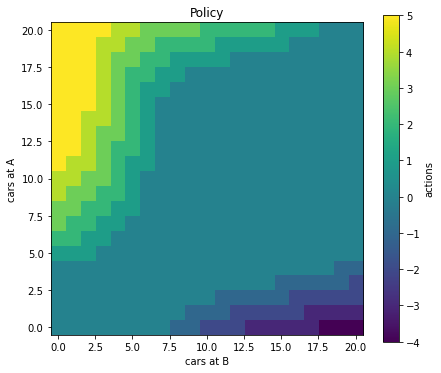

In [7]:
plt.figure(figsize=(7,6))
hmap = plt.imshow(policy_map, cmap='viridis', origin='lower')
cbar = plt.colorbar(hmap)
cbar.ax.set_ylabel('actions')
plt.title('Policy')
plt.xlabel("cars at B")
plt.ylabel("cars at A")

# Conclusion and outlook

Conclusion: yes we can turn JCR into a Gym environment and solve it using the exact same code we used to solve the Frozen Lake environment! 

So now what? One obvious area of improvement is speed: It takes too long to load the environment. Also the DP algorithm is slow, because it uses for loops instead of matrix operations.

Also currently the rewards that the environment returns are **average rewards** that are received when taking action *a* in state *s* . However, they do not match the actual amount of cars rented when transitioning from a particular state *s* to a new state *s'*. 

Finally, adding the modifications to the problem from Exercise 4.7 could also be implemented, but this complicates the calculation of **P** and **R** even further. 
For me, this is the real takeaway from this exercise: it is really hard to compute the complete set of proper transition probabilities and rewards for an MDP, but it is much easier if we just need to simulate single transitions according to the MDP specification. Wikipedia calls this [Simulator models](https://en.wikipedia.org/wiki/Markov_decision_process#Simulator_models).